In [16]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [18]:
spark = SparkSession.builder.appName('Play with pyspark ML on titatic_dataset').getOrCreate()
data = r"D:\spark_practice_data\train.csv"

df = spark.read.format("csv").option("header",'true').load(data)
df.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S


In [19]:
df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



C:\Users\bhagw\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Age distrubution Among all Passenger'}, xlabel='Age', ylabel='Density'>

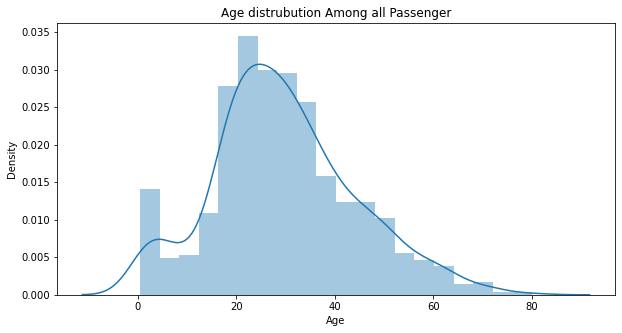

In [20]:
Pandas_df = df.toPandas()

plt.figure(figsize=(10,5))
plt.title('Age distrubution Among all Passenger')
sns.distplot(Pandas_df['Age'])

In [23]:
from pyspark.sql.functions import *

# Checking null values in Pyspark¶
isnan() is a function of the pysparq.sql.function package, we have to set which column we want to use as an argument of the function.
isNull()" belongs to pyspark.sql.Column package, to check the null status of a column
To check null in Pyspark, we use both function above

In [25]:
#using isnan function and isNull at in one query.

df.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df.columns]).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,0,177,0,0,0,0,687,2


In [29]:
#above query

df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,0,177,0,0,0,0,687,2


In [38]:
#removing cabin column because of extra null value

df = df.drop('Cabin')

To replace these NaN values, we can assign them the mean age of the dataset.But the problem is, there were many people with many different ages.

In 'Name' feature, we can see that the names have a salutation like Mr or Mrs. Thus we can assign the mean values of Mr and Mrs to the respective groups

Using the Regex ""[A-Za-z]+)." we extract the initials from the Name. It looks for strings which lie between A-Z or a-z and followed by a .(dot).

In [45]:
df=df.withColumn("Initial",regexp_extract(col("Name"),'([A-Za-z]+)\.',1))
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,S,Miss


In [50]:
# There are some misspelled Initials like Mlle or Mme that stand for Miss. we will replace them with Miss and same thing for other values.
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

In [56]:
df = df.withColumn('Age',col("Age").cast('int'))

In [57]:
df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Initial: string (nullable = true)



In [64]:
df.groupBy(col("Initial")).avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.84),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.472222222222222),
 Row(Initial='Mr', avg(Age)=32.72127139364303),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [71]:
# Assigning missing values in age feature based on average age of Initials
df = df.withColumn("Age",when((df["Initial"] == "Miss")   & (df["Age"].isNull()), 22).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Other")  & (df["Age"].isNull()), 46).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Master") & (df["Age"].isNull()), 5).otherwise( df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mr")     & (df["Age"].isNull()), 33).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mrs")    & (df["Age"].isNull()), 36).otherwise(df["Age"]))

In [73]:
df.groupBy(col("Embarked")).count().toPandas()

,Embarked,count
0,Q,77
1,None,2
2,C,168
3,S,644


In [74]:
# As we can see, Majority Passengers boarded from "S". We can assign missing value with "S"
df = df.na.fill({'Embarked':'S'})

df.groupBy(col("Embarked")).count().toPandas()

In [76]:
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,S,Miss


# After handling missing values, we do some simple feature engineering

In [101]:
#creating new column:Family_size
df = df.withColumn('Family_Size',col('SibSp') + col("Parch"))
df = df.withColumn('Alone',lit(0))
df = df.withColumn('Alone',when(col("Family_Size")==0,1).otherwise(col("Alone")))

In [93]:
df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- Initial: string (nullable = true)
 |-- Family_Size: double (nullable = true)
 |-- Alone: integer (nullable = false)



In [105]:
#converting Sex,Embarked,Initial column string to integer

df = df.select(*(col(c).cast("int").alias(c) for c in ['Sex','Embarked','Initial']))
df.printSchema()

root
 |-- Sex: integer (nullable = true)
 |-- Embarked: integer (nullable = true)
 |-- Initial: integer (nullable = true)

